# Autoencoders
## What are autoencoders?
Autoencoders are networks which have the same input and output. A set of data is fed to these networks and they are expected to recreate the input. However, what makes autoencoders interesting is that they compress the information into lower number of dimensions (a.k.a latent space) and then recreate the input using those dimensions. They can be used for dimensionality reduction similar to PCA, t-SNE, and Umap. Some of the advantages of using autoencoders compared to some of the other techniques are:
- Flexibility: You can design the network based on what the problem demands.
- Reversibility: Unlike methods such as t-SNE and UMAP you can convert data back to the initial space.
- Non-liearity: Unlike linear methods such as PCA, it is capable of using non-linear transformation.

## Structure
Autoencoders have two main components:
1. Encoder: Converts data to latent space.
2. Decoder: Converts the data back from latent space to its initial space.

The architecture looks similar to the image below:
<img src='./images/nn.svg' style='height:50rem'>

We pass the input through the model and it will compress and decompress the input and returns a result. Then we compare the output of the model with the original input. To check how close the output is to the original input we use a loss function.

Let's start by importing the required libraries.

In [14]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

from PIL import Image
from pathlib import Path
import numpy as np
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

## Problem Description
We are going to start with a simple problem. We will use MNIST dataset which is a collection of hand-written digits as 28x28 pixel images. We are going to use autoencoder to compress each image into only two values and then reconstruct the image. When the model is trained we will have a look at the reconstructed images as well as latent space values.

First we need to create a `Dataset` class. The `Dataset` class reads the data from file and returns data points when we need them. The advantage of using a `Dataset` is that we can adjust it based on what we need for each problem. If we are not dealing with large amount of data we can decide to keep everything in RAM so it is ready use. But if we are dealing with a few gigabytes of data we might need to open the file only when we need them.<br>
The MNIST data set is not large so we can easily fit it into memory. In the `Dataset` class we define a few methods:
- `__init__`: What information is required to create the object and how this information is saved.
- `__len__`: Returns the number of data points (images) when we use `len()` function.
- `__getitem__`: We can define how indexing would work for this class.

We are going to define a couple of custom functions for convinience:
- `show`: to see the image.
- `sample`: which returns a random sample of the data.

In [202]:
path = Path('../../data/processed/MNIST/')

class DigitsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, path, transform=None):

        self.root_dir = Path(path)
        self.transform = transform
        data = pd.read_csv(path)
        if 'label' in data.columns:
            self.x = data.drop(columns = ['label']).values
            self.y = data['label'].values
        else:
            self.x = data.values
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        output = self.x[idx]/255
        if self.transform:
            output = self.transform(output)
        return output
    
    def show(self,idx):
        plt.figure(figsize=(2,2))
        plt.imshow(self.x[idx].reshape((28,28)),'gray')

        
    def sample(self,n):
        idx = np.random.randint(0,len(self),n)
        return self[idx]
    

class ToTensor(object):
    def __call__(self, data):
        return torch.FloatTensor(data)
    

__Note:__ We also defined a class called `ToTensor`. This class takes an input and converts it to pytorch tensor. 

Now that we have a `Dataset` class, we can create a training and test dataset.

In [203]:
ds_train = DigitsDataset(path/'train.csv',transform=ToTensor())
ds_test = DigitsDataset(path/'test.csv',transform=ToTensor())

Next step is to create a data loaders. The training process takes place at multiple steps. At each step, we choose a few images and feed them to the model. Then we calculate the loss value based on the output. Using the loss value we update the values in the model. We do this over and over until when we think the model is trained. Each of these steps are called a mini-batch and the number of images passed in at each mini-batch is called batch size. Dataloader's job is to go to the dataset and grab a mini-batch of images for training. To create a Dataloader we use a pytorch dataloder object.

In [204]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    ds_train,
    batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(
    ds_test,
    batch_size = batch_size, shuffle = False)

__Note:__ Shuffle tells the data loader whether the data needs to be shuffled at the end of each epoch. We do it for training to keep the input random. But we don't need to do it for testing since we only use the test dataset for evaluation.

Now we need to create the model. The architecture we are going to use here is made of two linear layers for the encoder and two linear layers for the decoder.

In [205]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 2)
        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc2(h1)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        z = self.encode(x.view(-1, 784))
        return self.decode(z)

If we have access to GPU, let's make sure we are using it.

In [206]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Now we create an instance of the model.

In [194]:
model = AE().to(device)


We also need to choose an optimiser. The optimiser use the loss value and it's gradients with respect to model parameters and tells us how much each value must be adjusted to have a better model.

In [207]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

And the final component is the loss function. Here we are going to use Binary Cross Entropy function.

In [208]:
def loss_bce(recon_x, x):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    return BCE

Let's define two functions one for executing a single epoch of training and one for evaluating the mdel using test data.<br>
Notice the following steps in the training loop:
1. We make sure the data is in the right device (cpu or gpu)
2. We make sure that any saved gradient (derivative) is zeroed.
3. We pass a mini-batch of data into the model and grab the predictions.
4. We use the loss function to find out how close the model's output is to the actual image.
5. We use `loss.backward()` to claculate the derivative of loss with respect to model parameters.
6. We ask the optimiser to update model's parameters.

In [196]:
def train(epoch, loss_function, log_interval = 50):
    model.train()
    train_loss = 0
    for batch_idx, data  in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pct = 100. * batch_idx / len(train_loader)
            l = loss.item() / len(data)
            print(f'#{epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({pct:.0f}%)]\tLoss: {l:.6f}  ',
                 end = '\r',flush=True)
    print(f'#{epoch} Train loss: {train_loss / len(train_loader.dataset):.4f}')

def test(epoch, loss_function, log_interval = 50):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += loss_function(recon_batch, data).item()

    test_loss /= len(test_loader.dataset)
    print(f'#{epoch} Test loss: {test_loss:.4f}')
  


Now that all the components are ready, let's train the model for $10$ epochs.

In [197]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(epoch,loss_bce)
    test(epoch,loss_bce)

#1 Train loss: 179.3948Loss: 172.855164  
#1 Test loss: 164.1730
#2 Train loss: 160.7343Loss: 148.215378  
#2 Test loss: 157.9265
#3 Train loss: 156.3106Loss: 140.693451  
#3 Test loss: 154.8858
#4 Train loss: 153.5026Loss: 153.797043  
#4 Test loss: 153.0359
#5 Train loss: 151.4494Loss: 148.773285  
#5 Test loss: 151.1292
#6 Train loss: 149.8368Loss: 155.818146  
#6 Test loss: 149.6031
#7 Train loss: 148.4419Loss: 148.406174  
#7 Test loss: 148.8334
#8 Train loss: 147.2828Loss: 141.427551  
#8 Test loss: 148.0583
#9 Train loss: 146.3170Loss: 155.354034  
#9 Test loss: 147.5448
#10 Train loss: 145.4939Loss: 132.270782  
#10 Test loss: 146.7894


## Results
Now let's chack out the model.

In [242]:
def cvt2image(tensor):
    return tensor.detach().numpy().reshape(28,28)

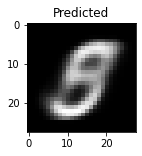

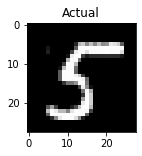

In [218]:
idx = np.random.randint(0,len(ds_test))

model.eval()
original = ds_train[[idx]]
result = model(original)
img = cvt2image(result[0])
plt.figure(figsize=(2,2))
plt.imshow(img,'gray')
plt.title('Predicted')
ds_train.show(idx)
plt.title('Actual');

<font color='blue' size='4rem'>Run the cell above a few times and compare the predicted and actual images.</font>

There are certainly some similarities but the predicted (reconstructed) images are not always very clear. We will shortly discuss how we can improve the model. But before that, let's have look at the latent space. The model is converting every image which has 784 values (28x28 pixels) to only 2 values. We can plot these two values for a few numbers.

In [219]:
res = model.encode(ds_train[:1000])
res = res.detach().numpy()

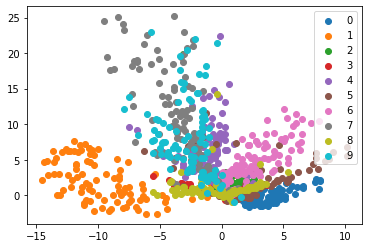

In [220]:
for i in range(10):
    idx = ds_train.y[:1000]==i
    plt.scatter(res[idx,0],res[idx,1],label = i)
plt.legend()

Each color represents a number. Despite most numbers overlapping, we can still see some distictions, for instance between $1$ and other numbers. 

## Improving the model
Obviously the model that we trained needs improvement as it is no recreating the images well enough. There are a few ways we can improve the model. One way is to create a deeper encoder and decoder. In the example above we ued only two layers for encoder and layers for decoder. This doesn't allow the model to comprehend complex relationships, especially in this scenario since we are working with images. By adding more layers we can give the model the opportunity to better differentiate between digits.
Another way of making the model is using more dimensions in latent space. For instance, if instead of compressing each image into two values we could use ten values. This will allow the model to extract more features from the input which will make reconstructing the image easier. However, it must be noted that whole point of using autoencoder is to force the model to compress the information into as few dimensions as possible.

## Application
Autoencoders are not only useful for dimensionality reduction. They are often used for other purposes as well, including:
1. __Denoising:__ We could add noise to the input and then feed it to the model and then compare the output with the original image (without noise). This approach will create a model which is capable of removing noise from the input.
2. __Anomaly Detection:__ When we train a model on specific set of data, the model learns how to recreate the dataset. As a result when there are uncommon instances in the data the model will not be able to recrate them very well. This behaviour is sometimes used as a technique to find anomalous data points. 

# Variational Autoencoders
Variational Autoencoders (VAE) are one of the variations of autoencoders. Unlike normal autoencoders which compress the data into a few values, VAEs tries to find the distribution of the data in latent space. As a result, the final model not only has the ability to recreate the input, but can also generate new outputs by sampling from the latent space distribution.

Since VAE is a variation of autoencoder, it has a similar architecture. The main difference between the two is an additional layer between encoder and decoder which samples from latent space distribution.
In a VAE, the encoder generates two values for each parameter in latent space. One represent the mean and one represents the standard deviation of the parameter. Then sampling layer uses these two numbers and generates random values from the same distribution. These values then are fed to decoder which will create an output similar to the input.

Let's create a VAE model. We will use layers with the same size as the previous model. Notice for the second layer we have two linear layers, one to generate the mean and one to generate the log of variance which will be converted into standard deviation.

In [221]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)
        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [222]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

The loss function is similar to what we used before, except we have an extra part. the extra equation is Kullback–Leibler divergence which measures difference between probability distributions.

In [226]:

def loss_bce_kld(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

We also need to slightly adjust the training loop since the loss function now takes four inputs.

In [224]:
def train(epoch, loss_function, log_interval = 50):
    model.train()
    train_loss = 0
    for batch_idx, data  in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data,mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pct = 100. * batch_idx / len(train_loader)
            l = loss.item() / len(data)
            print(f'#{epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({pct:.0f}%)]\tLoss: {l:.6f}  ',
                 end = '\r',flush=True)
    print(f'#{epoch} Train loss: {train_loss / len(train_loader.dataset):.4f}')

def test(epoch, loss_function, log_interval = 50):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data,mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f'#{epoch} Test loss: {test_loss:.4f}')
  


In [227]:
epochs = 10
for epoch in range(1, epochs + 1):
    train(epoch,loss_bce_kld)
    test(epoch,loss_bce_kld)


#1 Train loss: 186.2558Loss: 164.251694  
#1 Test loss: 169.1089
#2 Train loss: 166.6291Loss: 175.891449  
#2 Test loss: 164.5082
#3 Train loss: 163.0721Loss: 146.691330  
#3 Test loss: 161.7799
#4 Train loss: 160.8360Loss: 159.909607  
#4 Test loss: 160.1014
#5 Train loss: 159.0544Loss: 144.422394  
#5 Test loss: 158.3959
#6 Train loss: 157.7190Loss: 156.436371  
#6 Test loss: 157.2871
#7 Train loss: 156.6443Loss: 153.293839  
#7 Test loss: 156.8266
#8 Train loss: 155.7364Loss: 157.645508  
#8 Test loss: 155.7224
#9 Train loss: 155.0014Loss: 159.471802  
#9 Test loss: 155.1599
#10 Train loss: 154.3342Loss: 147.374161  
#10 Test loss: 154.6148


## Results

In [228]:
def cvt2image(tensor):
    return tensor.detach().numpy().reshape(28,28)

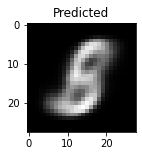

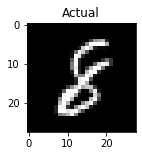

In [235]:
idx = np.random.randint(0,len(ds_test))

model.eval()
original = ds_train[[idx]]
result = model(original)
img = cvt2image(result[0])
plt.figure(figsize=(2,2))
plt.imshow(img,'gray')
plt.title('Predicted')
ds_train.show(idx)
plt.title('Actual');

Now let's plot the predicted mean of both parameters.

In [239]:
mu , logvar = model.encode(ds_train[:1000])

In [240]:
mu = mu.detach().numpy()


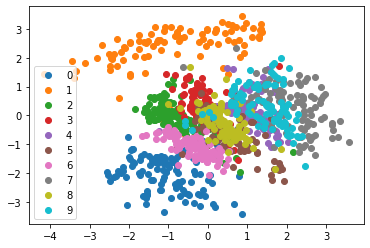

In [241]:
for i in range(10):
    idx = ds_train.y[:1000]==i
    plt.scatter(mu[idx,0],mu[idx,1],label = i)
plt.legend()

If we compare this plot with the similar plot for normal autoencoder, we can see that VAE did a better job at creating clusters. The points for each digits are closer together compared to previous model. However, there is still room for improvement. 

## Exercise 1
Create a new VAE but this time use a deeper network. Note, everything else (loss function, dataloaders, training loops, etc.) will stay the same only the model will change. The example above was using these sizes: 784 --> 400 --> 2 --> 400 --> 784
<br>Try a new model which uses these size: 784 --> 400 --> 80 --> 2 --> 80 --> 400 --> 784 

In [243]:
# Create the model definition

In [244]:
# Insert Training loop here

In [245]:
# Visualise the results

## Rocks

In [2]:
path = Path('../../data/processed/deep-rock-sr/DeepRockSR-2D/coal2D/coal2D_train_LR_default_X4/')


In [3]:
img_list = os.listdir(path)

In [4]:
rand_file = np.random.choice(img_list)
img = Image.open(path/rand_file)

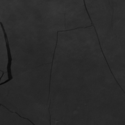

In [5]:
img

In [6]:
img.size

(125, 125)

In [146]:

encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(125**2,128),
                    nn.ReLU(),
#                     nn.BatchNorm1d(128),
                    nn.Linear(128,16),
                    nn.ReLU(),
#                     nn.BatchNorm1d(16),
                    nn.Linear(16,2),
                    nn.ReLU(),
#                     nn.BatchNorm1d(2)
                    )

decoder = nn.Sequential(
                    nn.Linear(2,16),
                    nn.ReLU(),
#                     nn.BatchNorm1d(16),
                    nn.Linear(16,128),
                    nn.ReLU(),
#                     nn.BatchNorm1d(128),
                    nn.Linear(128,125**2),
                    nn.Sigmoid(),
#                     nn.BatchNorm1d(2)
                    )

In [147]:
torch.utils.data.Dataset()

In [148]:
class RocksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, paths, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
#         self.root_dir = Path(root_dir)
        self.transform = transform
#         self.image_list = [i for i in self.root_dir.iterdir()]
        self.image_paths = paths
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.image_paths[idx]
        image = Image.open(img_name)
        image = np.array(image)/255
        if self.transform:
            image = self.transform(image[:,:,0])

        return image
    
class ToTensor(object):
    
    def __call__(self, image):
#         image = image.transpose((0, 1))
        return torch.FloatTensor(image).unsqueeze(0)
    


In [149]:
image_list = np.array([i for i in path.iterdir()])
is_train = np.random.binomial(1,.8,len(image_list))
list_tr = image_list[is_train==1]
list_val = image_list[is_train==0]

In [150]:
bs = 8
ds_tr = RocksDataset(list_tr,transform=ToTensor())
dl_tr = torch.utils.data.DataLoader(ds,bs,shuffle=True)
ds_val = RocksDataset(list_val,transform=ToTensor())
dl_val = torch.utils.data.DataLoader(ds,bs)

In [151]:
loss_function = F.mse_loss

In [152]:
model = nn.Sequential(encoder,decoder)

In [153]:
model(ds[0].unsqueeze(0))

tensor([[0.5015, 0.4684, 0.5446,  ..., 0.5209, 0.4901, 0.4860]],
       grad_fn=<SigmoidBackward>)

In [154]:
epochs = 10
opt = torch.optim.Adam(params = model.parameters())

In [155]:
from tqdm.auto import tqdm

In [156]:
for epoch in tqdm(range(epochs)):
    model.train()
    batch_loss = []
    for i, data in enumerate(dl_tr):
        opt.zero_grad()
        preds = model(data)
        train_loss = loss_function(data,preds.reshape_as(data))
        train_loss.backward()
        opt.step()
        batch_loss.append(train_loss.item())
        if i%50==0:
            print(f'{np.mean(batch_loss):.3f}')
    print('  *  '*10)
    
    model.eval()
    val_loss = []
    with torch.no_grad():
        for data in dl_val:
            preds = model(data)
            val_loss.append(loss_function(data,preds.reshape_as(data)).item())
    print(f'Validation loss: {np.mean(val_loss).item():.3f}')
    print('-'*50)
        
    
    

0.052
0.035
0.025
0.018
0.014
0.012
0.010
0.009
  *    *    *    *    *    *    *    *    *    *  
Validation loss: 0.002
--------------------------------------------------
0.003
0.002
0.002
0.002
0.002
0.002
0.002
0.002
  *    *    *    *    *    *    *    *    *    *  
Validation loss: 0.002
--------------------------------------------------
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
  *    *    *    *    *    *    *    *    *    *  
Validation loss: 0.002
--------------------------------------------------
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
  *    *    *    *    *    *    *    *    *    *  
Validation loss: 0.002
--------------------------------------------------
0.002
0.002
0.002
0.002
0.002
0.002
0.002
0.002
  *    *    *    *    *    *    *    *    *    *  
Validation loss: 0.002
--------------------------------------------------
0.003
0.002
0.002
0.002
0.002
0.002
0.002
0.002
  *    *    *    *    *    *    *    *    *    *  
Validation loss: 0.002
-------------

In [121]:
model.eval()
val_loss = []
with torch.no_grad():
    for data in dl_val:
        preds = model(data)
        val_loss.append(loss_function(data,preds.reshape_as(data)).item())
print(f'Validation loss: {np.mean(val_loss).item():.3f}')
print('-'*50)

Validation loss: 0.035
--------------------------------------------------


In [157]:
sample = ds_val[0].unsqueeze(0)

In [158]:
model.eval()
pred0 = model(sample)

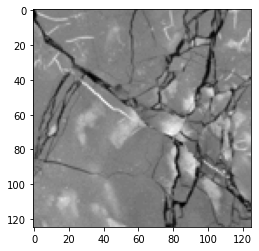

In [159]:
plt.imshow(sample.numpy()[0,0],'gray')

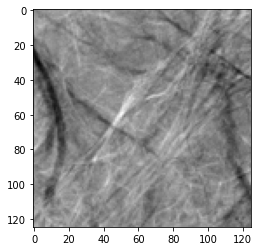

In [161]:
plt.imshow(pred0.detach().numpy().reshape((125,125)),'gray')

# Solution to Exercises

## Exercise 1
<details><summary>Solution</summary>

```Python
class VAE2(nn.Module):
    def __init__(self):
        super(VAE2, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 80)
        self.fc31 = nn.Linear(80, 2)
        self.fc32 = nn.Linear(80, 2)
        self.fc4 = nn.Linear(2, 80)
        self.fc5 = nn.Linear(80, 400)
        self.fc6 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc4(z))
        h4 = F.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    
model = VAE2().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
for epoch in range(1, epochs + 1):
    train(epoch,loss_bce_kld)
    test(epoch,loss_bce_kld)

# visualisations

model.eval()
mu , logvar = model.encode(ds_train[:1000])
mu = mu.detach().numpy()
for i in range(10):
    idx = ds_train.y[:1000]==i
    plt.scatter(mu[idx,0],mu[idx,1],label = i)
plt.legend()

```

</details>